viernes 03 de mayo de 2019  
  
_Benjamín Hernández Cortés_ - _Juan Pablo Rojas Rojas_  
_Departamento de Ingeniería Informática (DIINF)_  
_Universidad de Santiago de Chile (USACH)_


## Laboratorio 2 - Fundamentos de Aprendizaje Profundo con Redes Neuronales
___

El presente código está orientado hacia la implementación de un perceptrón multicapa o red neuronal de múltiples capas (Multi-Layer Neural Network). En primera oportunidad, se utilizará el perceptrón para clasificar y emular compuertas lógicas AND, OR y XOR, tanto de 2 como de 4 entradas. Luego, se realizará una clasificación trabajando con el conjunto de datos [wine](https://archive.ics.uci.edu/ml/datasets/wine) provenientes de la [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) que contiene 13 atributos en total y que intentan describir clases de vinos provenientes de 3 cultivos distintos.


#### Importación de bibliotecas
---

Las bibliotecas a emplear son:
- **Numpy:** Herramienta de computación científica, que nos permitirá trabajar a través de vectores
- **Pandas:** Para la manipulación y lectura de datos
- **Matplotlib:** Para la visualización gráfica de diversos datos de interés
- **Itertools:** Como herramienta para iteración de objetos
- **Scikit-learn:** Para la obtención del dataset _wine_ y el uso de herramientas de evaluación de desempeño para los perceptrones multicapa.

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as its
import sklearn as skl


from sklearn.datasets import load_wine
from sklearn import preprocessing

#### Definición de funciones globales
---

Para el presente laboratorio se emplearan las siguientes funciones de forma global, las cual estan enfocadas al cálculo de ciertos valores a partir de las entradas recibidas:

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `preprocessing(dataset)` |  <p style='text-align: justify;'>Se realiza el procesamiento del data set, en primer lugar se aplica el procedimiento de estandarizacion o eliminación media y escala de varianza con el objetivo de tener una varianza total acorde a los datos objetivos. Por ultimo se aplica normalización de datos</p>|

In [153]:
def preprocessing_data(dataset):
    data_col_names = dataset.columns.values
    for name in data_col_names[:-1]:
        a[name] = preprocessing.scale(a[name])
        a[name] = ((a[name] - a[name].min())/(a[name].max()-a[name].min())) 
    return dataset

#### 1. Implementar dos funciones de activación no lineal y una lineal.

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `sigmoid(x)` |  <p style='text-align: justify;'>Se calcula el valor para la función sigmoide (o logsig) aplicada a un conjunto de vectores $x$</p>|
| `sigmoid_derivative(x)` |  <p style='text-align: justify;'>Se calcula el valor de la derivada para la función sigmoide (o logsig) aplicada a un conjunto de vectores $x$</p>|
| `relu(x)` |  <p style='text-align: justify;'>Se calcula el valor para la función ReLU aplicada a un conjunto de vectores $x$</p>|
| `relu_derivative(x)` |  <p style='text-align: justify;'>Se calcula el valor de la derivada para la función ReLU aplicada a un conjunto de vectores $x$</p>|

In [154]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return 1 * (x > 0)

activation_functions = {
    'sigmoid': sigmoid,
    'relu': relu
}

activation_functions_derivatives = {
    'sigmoid': sigmoid_derivative,
    'relu': relu_derivative
}

#### Definición de la clase TruthTableGenerator
---

La clase TruthTableGenerator permite generar tablas de verdad para 3 tipos de compuertas lógicas: AND, OR y XOR.

En cuanto a las funciones definidas, se tiene:

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p>  |
| ------------ | ------------ |
| `generate_table(n_inputs, logic_gate)`  |  <p style='text-align: justify;'>Genera una tabla de verdad de n-variables (*n_inputs*), basada en una compuerta lógica determinada (*logic_gate*)</p>|

In [155]:
class TruthTableGenerator():
    
    def generate_table(n_inputs, logic_gate):
        table = its.product([0,1], repeat = n_inputs)
        table = pd.DataFrame(table)
        results = []
        
        for i in range(n_inputs ** 2):
            row = table.loc[[i]].values[0]
            if logic_gate == 'AND': results.append( int(all(row)) )
            elif logic_gate == 'OR': results.append( int(any(row)) )
            elif logic_gate == 'XOR':
                tmp_result = row[0] ^ row[1]
                for j in range(2, n_inputs):
                    tmp_result = tmp_result ^ row[j]
                results.append( tmp_result )
            else: return None
        
        table['result'] = results
        return table

#### Definición de la clase MLP
---
La clase MLP (Multilayer Perceptron) permite representar a un perceptrón multicapa configurable en el número de capas, número de neuronas por capa y las funciones de activación para cada capa:

| <p style='text-align: left;'>**Parámetro**</p> | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `network_config` |  <p style='text-align: justify;'>Lista de enteros. Define la cantidad de neuronas por cada capa; capas que debe incluir la de entrada, las ocultas y la de salida.</p>|
| `functions` | <p style='text-align: justify;'>Lista de strings. Define las funciones de activación que empleará cada capa de la red, las cuales pueden ser tangente hiperbólica (_tanh_), sigmoide (_sigmoid_) o ReLU (_relu_).</p> |

En cuanto a las funciones definidas, se tiene:

| <p style='text-align: left;'>**Función**</p>  | <p style='text-align: left;'>**Descripción**</p> |
| ------------ | ------------ |
| `feed_forward(x)` |  <p style='text-align: justify;'>Realiza una predicción para un conjunto de datos (*x*), empleando los valores actuales de los pesos (*weights*) asociados a la capa.</p>|
| `back_propagation(y, target, learning_rate)` |  <p style='text-align: justify;'>Realiza el ajuste de los pesos de la red, según un tasa de aprendizaje (*learning_rate*) y considerando un vector de salidas esperadas (*target*).</p>|
| `training(data, targets, learning_rate, epochs)` |  <p style='text-align: justify;'>Entrena la red neuronal, mediante un conjunto de datos inicial (*data*) a comparar con un conjunto de salidas esperadas (*targets*), empleando una tasa de aprendizaje (*learning_rate*) y una cantidad de iteraciones o épocas (*epochs*) definida por el usuario.</p>|
| `predict_single_input(x)` |  <p style='text-align: justify;'>Realiza una predicción para un único dato (*x*).</p>|
| `predict(x)` |  <p style='text-align: justify;'>Realiza una predicción para un conjunto de datos (*x*).</p>|


epochs: 10000
epochs: 20000
epochs: 30000


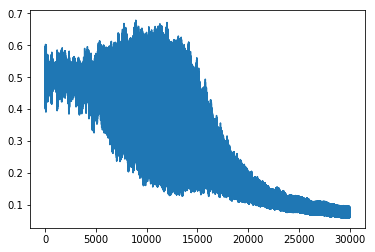

In [156]:
class MLP:
    def __init__(self, network_config, functions):
        self.layers = len(network_config)
        self.steps_per_epoch = 1
        self.network_config = network_config
        self.activity = []
        self.activity_derivative = []
        self.weights = []

        for layer in range(self.layers - 1):
            self.activity.append(activation_functions[functions[layer]])
            self.activity_derivative.append(activation_functions_derivatives[functions[layer]])
            w = np.random.rand(network_config[layer] + 1, network_config[layer + 1]) - 1
            w *= np.sqrt(1 / network_config[layer] + network_config[layer + 1])
            self.weights.append(w)
    
    def feed_forward(self, x):
        y = x

        for i in range(len(self.weights) - 1):
            activation = np.dot(y[i], self.weights[i])
            activity = self.activity[i](activation)
            activity = np.concatenate((np.ones(1), np.array(activity)))
            y.append(activity)

        activation = np.dot(y[-1], self.weights[-1])
        activity = self.activity[-1](activation)
        y.append(activity)
        return y
    
    def back_propagation(self, y, target, learning_rate):
        error = target - y[-1]
        delta_vector = [error * self.activity_derivative[-1](y[-1])]
        for i in range(self.layers-2, 0, -1):
            error = np.dot(delta_vector[-1], self.weights[i][1:].T)
            error = error * self.activity_derivative[i](y[i][1:])
            delta_vector.append(error)

        delta_vector.reverse()
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.network_config[i] + 1)
            delta = delta_vector[i].reshape(1, self.network_config[i + 1])
            self.weights[i] += learning_rate * np.dot(layer.T, delta)
    
    def training(self, data, targets, learning_rate=0.1, epochs=100):
        ones = np.ones((1, data.shape[0]))
        Z = np.concatenate((ones.T, data), axis=1)
        errors = []
        
        for k in range(epochs):
            if (k+1) % 10000 == 0:
                print('epochs: {}'.format(k+1))
        
            sample = np.random.randint(X.shape[0])
            x = [Z[sample]]
            y = self.feed_forward(x)
            target = targets[sample]
            errors.append(np.absolute(y[-1] - target))
            self.back_propagation(y, target, learning_rate)
        
        return errors
    
    def predict_single_input(self, x):
        val = np.concatenate((np.ones(1).T, np.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activity[i](np.dot(val, self.weights[i]))
            val = np.concatenate((np.ones(1).T, np.array(val)))
        return val[1]
    
    def predict(self, X):
        Y = np.array([]).reshape(0, self.network_config[-1])
        for x in X:
            y = np.array([[self.predict_single_input(x)]])
            Y = np.vstack((Y,y))
        return Y
            
                
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

    

a = sklearn_to_df(load_wine())
b = np.array(TruthTableGenerator.generate_table(n_inputs=2, logic_gate='XOR'))

perceptron = MLP([2,2,1], ['sigmoid','sigmoid','sigmoid'])
X = b[:,:-1]
y = b[:,-1]


error = perceptron.training(X, y, epochs=30000)


plt.plot(error)
plt.show()

#### 2. Implementar   una   red   MLP   con   solo   una   capa   oculta   de   forma   genérica   para   las  diferentes funciones de activación. 

In [157]:
#Entradas: 4
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Sigmoid
perceptron_sigmoid_4 = MLP([4,2,1], ['sigmoid','sigmoid','sigmoid'])
#Entradas: 4
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Relu
perceptron_relu_4 = MLP([4,2,1], ['relu','relu','relu'])
#____________________________________________________________________#
#Entradas: 2
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Relu
perceptron_sigmoid_2 = MLP([2,2,1], ['sigmoid','sigmoid','sigmoid'])
#Entradas: 2
#Neuronas: 2 capa escondida,1 capa salida
#Activación: Relu
perceptron_relu_2 = MLP([2,2,1], ['relu','relu','relu'])

#### 3. Probar   la   red   neuronal   con   las   compuertas   AND,   OR   y   XOR   para   entradas   de   tamaño  2 y 4 (+ Bias). 

In [158]:
#Tamaño 2
XOR_2 = np.array(TruthTableGenerator.generate_table(n_inputs=2, logic_gate='XOR'))
AND_2 = np.array(TruthTableGenerator.generate_table(n_inputs=2, logic_gate='AND'))
OR_2 = np.array(TruthTableGenerator.generate_table(n_inputs=2, logic_gate='OR'))
#Tamaño 4
XOR_4 = np.array(TruthTableGenerator.generate_table(n_inputs=4, logic_gate='XOR'))
AND_4 = np.array(TruthTableGenerator.generate_table(n_inputs=4, logic_gate='AND'))
OR_4 = np.array(TruthTableGenerator.generate_table(n_inputs=4, logic_gate='OR'))
#__________________________________________________________________________________#

#____________________________2 Entradas____________________________________________#
#XOR
error_xs2 = perceptron_sigmoid_2.training(XOR_2[:,:-1],XOR_2[:,-1],epochs = 10000)
error_xr2 = perceptron_relu_2.training(XOR_2[:,:-1],XOR_2[:,-1],epochs = 10000)
#AND
error_as2 = perceptron_sigmoid_2.training(AND_2[:,:-1],AND_2[:,-1],epochs = 10000)
error_ar2 = perceptron_relu_2.training(AND_2[:,:-1],AND_2[:,-1],epochs = 10000)
#OR
error_os2 = perceptron_sigmoid_2.training(OR_2[:,:-1],OR_2[:,-1],epochs = 10000)
error_or2 = perceptron_relu_2.training(OR_2[:,:-1],OR_2[:,-1],epochs = 10000)



#____________________________4 Entradas____________________________________________#
#XOR
error_xs4 = perceptron_sigmoid_4.training(XOR_4[:,:-1],XOR_4[:,-1],epochs = 10000)
error_xr4 = perceptron_relu_4.training(XOR_4[:,:-1],XOR_4[:,-1],epochs = 10000)
#AND
error_as4 = perceptron_sigmoid_4.training(AND_4[:,:-1],AND_4[:,-1],epochs = 10000)
error_ar4 = perceptron_relu_4.training(AND_4[:,:-1],AND_4[:,-1],epochs = 10000)
#OR
error_os4 = perceptron_sigmoid_4.training(OR_4[:,:-1],OR_4[:,-1],epochs = 10000)
error_or4 = perceptron_relu_4.training(OR_4[:,:-1],OR_4[:,-1],epochs = 10000)


epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000
epochs: 10000


#### 4. Mostrar   el   resultado   del   entrenamiento   mediante   un   gráfico   ​ Iteración   vs   Error   para  cada compuerta lógica.

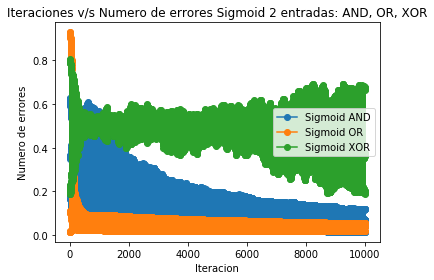

In [164]:
plt.plot(range(1,10000 + 1), error_as2, marker= "o", label = "Sigmoid AND")
plt.plot(range(1,10000 + 1), error_os2, marker= "o", label = "Sigmoid OR")
plt.plot(range(1,10000 + 1), error_xs2, marker= "o", label = "Sigmoid XOR")
plt.title("Iteraciones v/s Numero de errores Sigmoid 2 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Numero de errores")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()


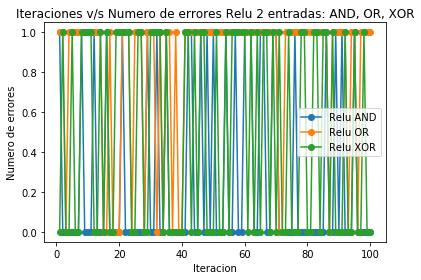

In [163]:
plt.plot(range(1,100 + 1), error_ar2[:100], marker= "o", label = "Relu AND")
plt.plot(range(1,100 + 1), error_or2[:100], marker= "o", label = "Relu OR")
plt.plot(range(1,100 + 1), error_xr2[:100], marker= "o", label = "Relu XOR")
plt.title("Iteraciones v/s Numero de errores Relu 2 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Numero de errores")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()

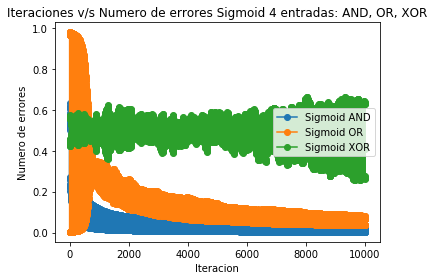

In [161]:
plt.plot(range(1,10000 + 1), error_as4, marker= "o", label = "Sigmoid AND")
plt.plot(range(1,10000 + 1), error_os4, marker= "o", label = "Sigmoid OR")
plt.plot(range(1,10000 + 1), error_xs4, marker= "o", label = "Sigmoid XOR")
plt.title("Iteraciones v/s Numero de errores Sigmoid 4 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Numero de errores")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()

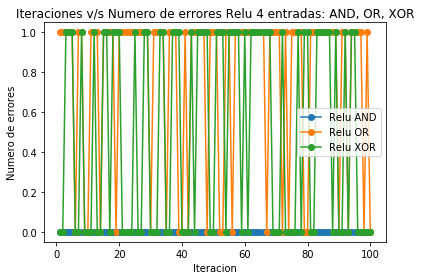

In [168]:
plt.plot(range(1,100 + 1), error_ar4[:100], marker= "o", label = "Relu AND")
plt.plot(range(1,100 + 1), error_or4[:100], marker= "o", label = "Relu OR")
plt.plot(range(1,100 + 1), error_xr4[:100], marker= "o", label = "Relu XOR")
plt.title("Iteraciones v/s Numero de errores Relu 4 entradas: AND, OR, XOR")
plt.xlabel("Iteracion")
plt.ylabel("Numero de errores")
plt.legend(loc = "center right")
plt.tight_layout()
plt.show()

#### 5. Analizar los resultados obtenidos y compararlos con el perceptrón simple.

El perceptrón simple fue muy efectivo para los datos de tablas que son linealmente separables, es decir, para entradas AND y OR, a diferencia de XOR en el que estuvo oscilando entre errores sin un entrenamiento correcto,porque como bien se dijo, solo funciona con clases linealmente separables.
Ahora bien en esta oportunidad se presentan 4 gráficos con resultados obtenidos dadas 10.000 iteraciones de entrenamiento por cada tabla de verdad:

    - En el uso de funciones de activación Sigmoid para 4 y 2 entradas se aprecia un comportamiento similar, para ambos casos el entrenamiento de compuerta tipo XOR, se mantuvo en oscilacion en un margen de error, no siendo posible llevar este a 0. Caso contrario para compuertas tipo AND y OR, el error a medida que la iteración crece converge a 0. Un Caso similar al perceptron simple.
    - En el segundo caso, para funciones de activación tipo Relu de 2 entradas, se presentan las 100 primeras iteraciones para apreciar el comportamiento que se repite a lo largo de las 10.000 iteraciones, es posible apreciar una oscilacion en el margen de error, por lo que no converge en su totalidad. En el caso de Relu con 4 entradas, la convergencia se aplica para la compuerta AND.
    
Cabe destacar que la imposibilidad de convergencia de casos anteriores para un perceptron multicapa, que deberia ser posible ser aplicado en clases que no son linealmente separables, se debe a que en muchos de los casos de entrenamiento al minimizar la funcion del error se cae en muchos minimos locales, por lo que para realizar su correcto funcionamiento es necesario aplicar procedimientos de mejoras, ya que en este caso el perceptron simple es mucho más efectivo, exceptuando por